In [3]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from pymongo import MongoClient
import collections
import matplotlib.pyplot as plt
import re
from random import choices
import string
nltk.download('popular', quiet = 'true')

True

In [4]:
#Mongo DB Information
client = MongoClient('localhost', 27017)
db = client['twitter2']  
streaming_collection = db['streaming']
rest_collection = db['rest']
updated_geo = db['geo']

In [5]:
rest_rt = list(rest_collection.find({"retweeted_status":{"$exists": False}}))
streaming_rt = list(streaming_collection.find({"retweeted_status":{"$exists": False}}))
combined_list = rest_rt + streaming_rt
distinct_list = list({tweet['id']:tweet for tweet in combined_list}.values())
len(distinct_list)

4419

In [6]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t, 'n') for t in word_tokenize(doc)]

In [20]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer() ,
                             stop_words = "english", 
                             strip_accents = 'unicode',
                             lowercase = True,
                             min_df = 2,)
#                              max_features = int((len(distinct_list)/10)))

In [8]:
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer() ,
                             stop_words = "english", 
                             strip_accents = 'unicode',
                             lowercase = True,
                             min_df = 2,)
#                              max_features = int((len(distinct_list)/10)))

In [28]:
corpus = []
translation = str.maketrans('','', string.punctuation)
for tweets in distinct_list:
    text = tweets['text']
    text = re.sub(r"http\S+", "", text) # remove links
    text = "".join(filter(lambda x: x in string.printable, text)) #remove non ascii
#     text = "".join([i for i in text if not i.isdigit()]) #remove digits
#     text = text.translate(translation) #remove puntuations
    text = re.sub(r'\b\w{1,3}\b', '', text) #remove characters less than 3
    tokenized = word_tokenize(text)
    text = " ".join([word for (word, pos) in nltk.pos_tag(tokenized) if pos.startswith('N')])
    corpus.append(text)
X = vectorizer.fit_transform(corpus)

In [30]:
len(vectorizer.get_feature_names()), X.toarray()

(2211, array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [22]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs = -1, max_iter = 1000).fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

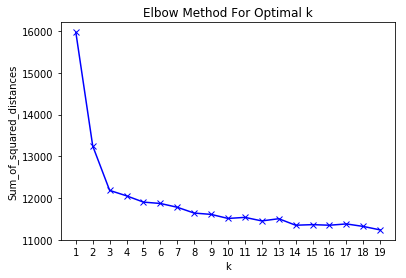

In [23]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xticks(K)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
kmeans = KMeans(n_clusters= 3,
                n_jobs = -1).fit(X)

In [35]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
collections.Counter(labels), labels

(Counter({0: 4221, 1: 56, 2: 142}), array([0, 0, 0, ..., 0, 0, 0]))

In [44]:
list_size = len(collections.Counter(labels))
list_size

3

In [65]:
list_size = len(collections.Counter(labels))
geo_tagged = [0] * list_size
profile_location = [0] * list_size
cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        geo_tagged[index] +=1
        key =  distinct_list[i]['place']['full_name'] 
        if key in cluster[index]:
            cluster[index][key] +=1
        else:
            cluster[index][key] = 1
    if distinct_list[i]['user']['location'] is not None:
        profile_location[index] +=1
geo_tagged, profile_location

([360, 5, 9], [4162, 56, 142])

In [66]:
cluster[2]

{'West Region, Singapore': 2,
 'Central Region, Singapore': 4,
 'East Region, Singapore': 3}

In [67]:
def count_location_weights(cluster,list_size):
    location = []
    weights = []
    for i in range(0,list_size):
        for key in cluster[i]:
            cluster[i][key] = cluster[i][key]/geo_tagged[i] * 100
        location.append(list(cluster[i].keys()))
        weights.append(list(cluster[i].values()))
#         for key in cluster[i]:
#             counter = cluster[i][key]
#             cluster[i][key] = counter/geo_tagged[i] * 100
#             location.append(list(cluster[i].keys()))
#             weights.append(list(cluster[i].values()))
    return location, weights

In [68]:
location, weights = count_location_weights(cluster, list_size)
location, weights

([['Singapore',
   'Central Region, Singapore',
   'East Region, Singapore',
   'West Region, Singapore',
   'North Region, Singapore',
   '中区, 新加坡',
   '北区, 新加坡',
   '东北区, 新加坡',
   'North-East Region, Singapore',
   'The Projector',
   'Terminal 2 Departure Hall',
   'Spago',
   'The Helix Bridge',
   '东区, 新加坡',
   'The Ritz-Carlton, Millenia Singapore'],
  ['Central Region, Singapore'],
  ['West Region, Singapore',
   'Central Region, Singapore',
   'East Region, Singapore']],
 [[2.2222222222222223,
   45.27777777777778,
   19.72222222222222,
   12.5,
   5.555555555555555,
   0.8333333333333334,
   0.5555555555555556,
   1.3888888888888888,
   9.722222222222223,
   0.2777777777777778,
   0.2777777777777778,
   0.2777777777777778,
   0.2777777777777778,
   0.8333333333333334,
   0.2777777777777778],
  [100.0],
  [22.22222222222222, 44.44444444444444, 33.33333333333333]])

In [69]:
#assigning geo based on probabilistic model
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is None:
        distinct_list[i]['assigned_geo'] = choices(location[index],weights[index])

In [86]:
list_size = len(collections.Counter(labels))
geo_counter = [0] * list_size
training_cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        if int(geo_tagged[index]/2) != geo_counter[index]:
            geo_counter[index] += 1
            key =  distinct_list[i]['place']['full_name']
            distinct_list[i]["training"] = True
            if key in training_cluster[index]:
                training_cluster[index][key] +=1
            else:
                training_cluster[index][key] = 1
        else:
            distinct_list[i]["training"] = False

training_location, training_weights = count_location_weights(training_cluster, list_size) 

percentage = [0]* list_size 
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None and distinct_list[i]["training"] is False:
        assigned = choices(training_location[index],training_weights[index])[0]
        if assigned == distinct_list[i]['place']['full_name']:
            percentage[index] += 1
            
for i in range(len(percentage)):
    if geo_tagged[i] == 0:
        print(f"No assignment possible due to no geo tweets in cluster {i}")
    else:
        print(f"Acuracy using 50% as training data and 50% as assignment for cluster {i}: {percentage[i]/(geo_tagged[i]/2) * 100}")

Acuracy using 50% as training data and 50% as assignment for cluster 0: 25.0
Acuracy using 50% as training data and 50% as assignment for cluster 1: 120.0
Acuracy using 50% as training data and 50% as assignment for cluster 2: 22.22222222222222
